# FC2: Reinforcement Learning

This code is based on https://github.com/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb

and contains parts from https://pastebin.com/wqKECmck#google_vignette

# Setup

First we mount our Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This project requires Python 3.7 or above:

In [2]:
import sys
assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

TensorFlow is an open-source software library for machine learning and artificial intelligence. It provides a range of tools and libraries that allow developers to create and train complex neural networks, among other machine learning models.

In [3]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

We define the default font sizes to make the figures prettier. We will also display some Matplotlib animations.

In [4]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

And let's create the `images/rl` folder in our drive, and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path('/content/drive/My Drive/images/FC2')
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This program can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [6]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


Let's install the Gymnasium library, which provides many environments for Reinforcement Learning. We'll also install the extra libraries needed for classic control environments (including CartPole, which we will use shortly), as well as for Box2D and Atari environments, which are needed for the exercises.

The text you've selected refers to environments provided by the OpenAI Gym, a toolkit for developing and comparing reinforcement learning algorithms.

1. **CartPole**: This is a classic reinforcement learning environment where the goal is to balance a pole on a cart. The agent needs to move the cart left or right in order to keep the pole balanced upright.

2. **Box2D**: This is a 2D physics engine. OpenAI Gym provides several environments that use Box2D for more complex tasks that involve physics simulations.

3. **Atari**: OpenAI Gym includes a variety of environments based on classic Atari games. These environments render the game screen pixel by pixel, and the agent must learn to play the game based on the pixel data.

by running the following cell, you accept the Atari ROM license.

In [7]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

# Environment

In this notebook we will be using [gymnasium](https://github.com/Farama-Foundation/Gymnasium), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's import Gym and make a new CartPole environment:

In [8]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

gym: This is the OpenAI Gym module, which provides a collection of environments for testing reinforcement learning algorithms.

make(): This function is used to create a specific environment. The name of the environment to be created is passed as a string argument.

"CartPole-v1": This is the ID of the environment to be created. In this case, it's creating an instance of the CartPole environment, version 1. In this environment, the task is to balance a pole on a cart for as long as possible by moving the cart left and right.

render_mode="rgb_array": This is an optional argument that specifies how the environment should be rendered. By setting render_mode to "rgb_array", the env.render() method will return an array representing RGB image data.

Let's initialize the environment by calling is `reset()` method. This returns an observation, as well as a dictionary that may contain extra information. Both are environment-specific.

In [9]:
obs, info = env.reset(seed=42)
obs1 = obs
obs1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In the case of the CartPole, each observation is a 1D NumPy array composed of 4 floats: they represent

- the cart's horizontal position
- its velocity
- the angle of the pole (0 = vertical)
- and the angular velocity.

An environment can be visualized by calling its `render()` method. If you set `render_mode` to `"rgb_array"` when creating the environment, then this will return a NumPy array.

In [10]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

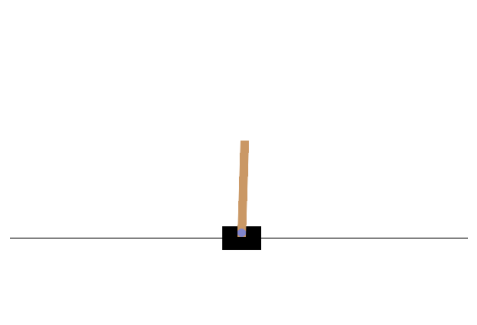

In [11]:
# creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)     # Create a new figure with the specified size
    img = env.render()              # Render the environment and get the resulting image
    plt.imshow(img)                 # Display the image using matplotlib
    plt.axis("off")
    return img

plot_environment(env)
save_fig("cart_pole_plot_1")
plt.show()

This function plot_environment takes an environment env and a tuple figsize specifying the size of the figure to be created. It renders the environment, displays the resulting image using matplotlib, and then returns the image. The axes for the plot are turned off with plt.axis("off") to only display the image. The function is then called with env as the argument to render and plot the environment, and plt.show() is used to display the plot.

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [12]:
env.action_space

Discrete(2)

Just two possible actions: accelerate towards the left (0) or towards the right (1).

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [13]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
print(obs, obs1)

[ 0.02727336  0.18847767  0.03625453 -0.26141977] [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

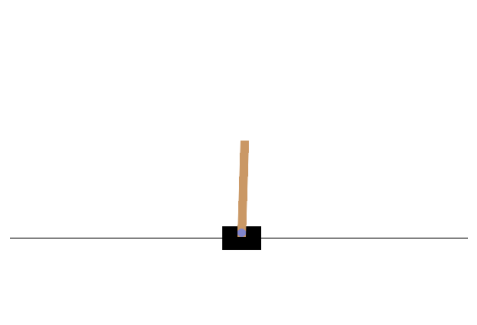

In [14]:
# displays the environment
plot_environment(env)
save_fig("cart_pole_plot_2")
plt.show()

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [15]:
reward

1.0

When the game is over, the environment returns `done=True`. In this case, it's not over yet:

In [16]:
done

False

Some environment wrappers may want to interrupt the environment early. For example, when a time limit is reached or when an object goes out of bounds. In this case, `truncated` will be set to `True`. In this case, it's not truncated yet:

In [17]:
truncated

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training.

In [18]:
info

{}

The sequence of steps between the moment the environment is reset until it is done or truncated is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True` or `truncated=True`), you should reset the environment before you continue to use it.

In [19]:
if done or truncated:
    obs, info = env.reset()

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

This function defines a very basic policy that decides what action to take based on the angle of the pole. If the angle is less than 0, it moves the cart to the left (action 0). If the angle is greater than or equal to 0, it moves the cart to the right (action 1).
The goal of this code is to see how well the basic policy performs over 500 episodes. The total reward for each episode (which is a measure of how well the policy did) is stored in the totals list.

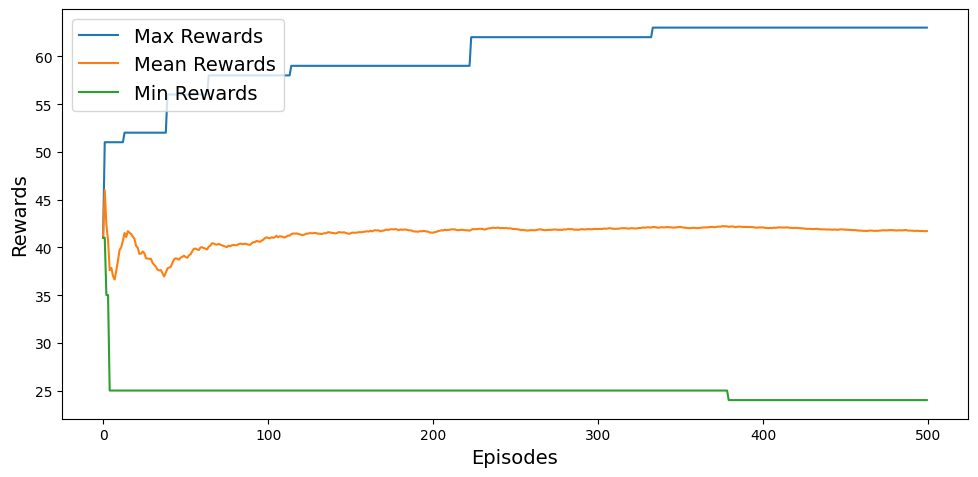

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []                 # This list will hold the total rewards for each episode
max_totals = []             # This list will hold the maximum total reward seen so far
mean_totals = []            # This list will hold the mean total reward so far
std_totals = []             # This list will hold the standard deviation of total rewards so far
min_totals = []             # This list will hold the minimum total reward seen so far

for episode in range(500):
    episode_rewards = 0     # Initial reward for this episode
    obs, info = env.reset(seed=episode) # Reset the environment for the start of the new episode
    for step in range(200):
        action = basic_policy(obs)      # Get the action to take based on the current observation
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward       # Add the reward to the total rewards for this episode
        if done or truncated:           # If the episode is done (the pole has fallen over) or truncated (the step limit has been reached), exit the loop
            break

    totals.append(episode_rewards)  # Append the total rewards for this episode to the list of total rewards
    max_totals.append(max(totals))  # Append the maximum total reward seen so far to the list
    mean_totals.append(sum(totals) / len(totals))  # Append the mean total reward so far to the list
    std_totals.append(np.std(totals))  # Append the standard deviation of total rewards so far to the list
    min_totals.append(min(totals))  # Append the minimum total reward seen so far to the list

# Plot max_totals, mean_totals, std_totals, and min_totals
plt.figure(figsize=(10, 5))
plt.plot(max_totals, label='Max Rewards')
plt.plot(mean_totals, label='Mean Rewards')
plt.plot(min_totals, label='Min Rewards')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
save_fig("basic_policy_rewards")
plt.show()

In [21]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

The `totals` list contains the total rewards obtained in each episode. `totals` is a list where each element is the total reward obtained in a single episode. The total reward for an episode is the sum of the rewards obtained at each step of the episode. The reward at each step is returned by the `env.step(action)` function, which also returns the new observation and a flag indicating whether the episode is done.

- np.mean(totals): This is the average total reward per episode over all episodes.

- np.std(totals): This is the standard deviation of the total rewards per episode. It measures how much the rewards per episode vary from the average reward.

- min(totals): This is the minimum total reward obtained in any episode. In your case.

- max(totals): This is the maximum total reward obtained in any episode.

These statistics gives us a sense of how well your policy is performing. The higher the average reward and the lower the standard deviation, the better our policy is. The minimum and maximum rewards give you a sense of the range of rewards your policy is achieving.

mmm... the policy as we defined it cant learn 😞

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 63 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode.

In [22]:
from matplotlib.animation import PillowWriter

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, name, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    anim.save(name, writer=PillowWriter(fps=30))  # save as gif
    plt.close()
    return anim

def show_one_episode(policy, name, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    full_path = IMAGES_PATH / name
    return plot_animation(frames, full_path, name)

In [23]:
show_one_episode(basic_policy, name = 'basic_policy.gif')

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

In [24]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


`model = tf.keras.Sequential([...])`: This line creates a new sequential model using TensorFlow's Keras API. A sequential model is a linear stack of layers, where each layer has exactly one input tensor and one output tensor.

`tf.keras.layers.Dense(5, activation="relu")`: This line adds a dense layer to the model. A dense layer, also known as a fully connected layer, means that each neuron in this layer is connected to every neuron in the previous layer. The first argument, `5`, specifies the number of neurons in this layer. The `activation="relu"` parameter sets the activation function of this layer to Rectified Linear Unit (ReLU). ReLU is commonly used in hidden layers because it helps introduce non-linearity into the model.

`tf.keras.layers.Dense(1, activation="sigmoid")`: This line adds another dense layer to the model. This time, it has only 1 neuron, which is typical for binary classification problems where the model needs to output a probability indicating the likelihood of a sample belonging to a particular class. The `activation="sigmoid"` parameter sets the activation function of this layer to the sigmoid function. The sigmoid function squashes the output between 0 and 1, which is useful for binary classification tasks as it can be interpreted as a probability.

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment.

Why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability? This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well.

Let's write a small policy function that will use the neural net to get the probability of moving left, then let's use it to run one episode:

In [25]:
def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy, name = 'pg_policy.gif')

The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

Let's see if it can learn a better policy on its own.

# Policy Gradients

To train this neural network we will need to define the target probabilities **y**. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions near positive rewards slightly more likely, while actions near negative rewards are made slightly less likely. First we play, then we go back and think about what we did.

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients. We will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be.

In [26]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when you cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [27]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn): # ejecuta varios episodios en el ambiente y devuelve las recompensas y los gradientes obtenidos en cada paso
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset() # resetea el ambiente
        for step in range(n_max_steps): # ejecuta un número máximo de pasos por episodio (200 en este caso)
            obs, reward, done, truncated, grads = play_one_step( # ejecuta un paso en el ambiente y obtiene el gradiente de la función de pérdida con respecto a los parámetros del modelo de política (la red neuronal)
                env, obs, model, loss_fn)
            current_rewards.append(reward) # almacena la recompensa obtenida en el paso actual
            current_grads.append(grads) # almacena el gradiente obtenido en el paso actual
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [28]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [29]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [30]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [31]:
n_iterations = 150
n_episodes_per_update = 4
n_max_steps = 200
discount_factor = 0.95

In [32]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
obs, info = env.reset(seed=42)

create the network, with 5 neurons and the ReLU activation function
create the output layer, with 1 neuron and the sigmoid activation function

In [33]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

optimizer calculates the change in the weights and biases of the neural network
We are using the Nadam optimizer, which is a combination of Nesterov Accelerated Gradient (NAG) and Adam
Adam is an optimizer that calculates the change in the weights and biases of the neural network
learning_rate is the learning rate, which is the amount that the weights and biases of the neural network are updated in each iteration
The learning rate is 0.01
NAG is an optimizer that calculates the change in the weights and biases of the neural network
The Nadam optimizer is a combination of NAG and Adam

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py:291: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self._numpy())


Iteration: 1/150, mean rewards: 24.2, max reward: 60.0
Iteration: 2/150, mean rewards: 13.8, max reward: 19.0
Iteration: 3/150, mean rewards: 20.5, max reward: 28.0
Iteration: 4/150, mean rewards: 15.2, max reward: 19.0
Iteration: 5/150, mean rewards: 18.0, max reward: 23.0
Iteration: 6/150, mean rewards: 37.5, max reward: 51.0
Iteration: 7/150, mean rewards: 30.5, max reward: 57.0
Iteration: 8/150, mean rewards: 25.0, max reward: 37.0
Iteration: 9/150, mean rewards: 27.0, max reward: 52.0
Iteration: 10/150, mean rewards: 30.0, max reward: 49.0
Iteration: 11/150, mean rewards: 19.2, max reward: 45.0
Iteration: 12/150, mean rewards: 22.0, max reward: 29.0
Iteration: 13/150, mean rewards: 18.0, max reward: 34.0
Iteration: 14/150, mean rewards: 19.8, max reward: 25.0
Iteration: 15/150, mean rewards: 14.0, max reward: 17.0
Iteration: 16/150, mean rewards: 26.8, max reward: 43.0
Iteration: 17/150, mean rewards: 30.5, max reward: 59.0
Iteration: 18/150, mean rewards: 33.5, max reward: 42.0
I

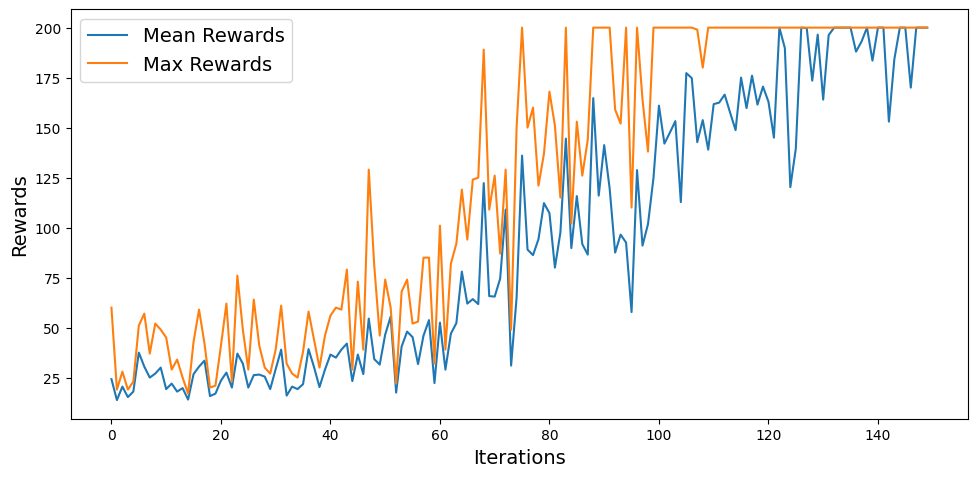

In [34]:
import matplotlib.pyplot as plt

# Initialize lists to store data
iterationspg = []
mean_rewardspg = []
max_rewardspg = []

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # Calculate total rewards and mean rewards
    total_rewards = sum(map(sum, all_rewards))
    mean_reward = total_rewards / n_episodes_per_update

    # Print debug info
    print(f"\rIteration: {iteration + 1}/{n_iterations}, mean rewards: {mean_reward:.1f}", end="")

    # Calculate and print the maximum reward
    max_reward = max([sum(rewards) for rewards in all_rewards])
    print(f", max reward: {max_reward}")

    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)

    # Append data to lists
    iterationspg.append(iteration)
    mean_rewardspg.append(mean_reward)
    max_rewardspg.append(max_reward)

    # Calculate the average gradient for each variable of the neural network
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    # Apply the average gradient to the weights and biases of the neural network
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

# Plot mean_rewards and max_rewards
plt.figure(figsize=(10, 5))
plt.plot(iterationspg, mean_rewardspg, label='Mean Rewards')
plt.plot(iterationspg, max_rewardspg, label='Max Rewards')
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.legend()
save_fig("pg_policy_rewards")
plt.show()

it learned!! ☝️🤓
however, it cost a lot *A LOT* of time, buu

In [35]:
np.random.seed(42)
show_one_episode(pg_policy, name = 'pg_policy_final.gif')

haha goodbye! 👋

# Q-Learning

We have to discretize in order to use the _Q-Learning_ method, and we define the parameters. Discretization of the observation space is necessary for Q-learning algorithms as it allows us to represent a continuous state space in a discrete form, making it easier for the agent to learn and generalize. Without discretization, the agent would have to deal with continuous state space, making learning difficult and computationally expensive.
We set `max_ep` to 1000 for the maximum number of training episodes and `reward_update_interval` to 500 for updating the reward at intervals. `learning_coeff` and `exploration_coeff` control the learning rate and exploration-exploitation trade-off respectively, with their values needing fine-tuning to balance exploration and exploitation effectively. For discretization, we use a tuple `n_bins` to specify the number of bins for each state value, and `lower_bounds` and `upper_bounds` to set the range of values for each state before discretization.


In [36]:
max_ep = 1000                  # Maximum number of steps in each episode.
reward_update_interval = 500   # Interval for updating the reward.
learning_coeff = 500           # Coefficient for learning rate decay.
exploration_coeff = 500        # Coefficient for exploration rate decay.

# Number of bins for discretizing the continuous state space. Each element in the tuple represents the number of bins for one observation.
n_bins = (1, 1, 8, 3)

# Lower and upper bounds for the observations. These are used for discretizing the continuous state space.
lower_bounds = [env.observation_space.low[0], env.observation_space.low[1], env.observation_space.low[2], -np.radians(50)]
upper_bounds = [env.observation_space.high[0], env.observation_space.high[1], env.observation_space.high[2], np.radians(50)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Initializing the Q-Table

In this step, we initialize the Q-table with zeros to start the Q-learning process. The Q-table has a specific size determined by the tuple `n_bins` representing the number of bins for each observation in the environment, added to the number of actions in the action space (`env.action_space.n`). This ensures that each possible state-action pair has a corresponding Q-value entry in the table. By initializing the Q-table with zeros, we start with no prior knowledge about the environment, allowing the agent to learn and update Q-values through interactions with the environment.


In [37]:
Q_table = np.zeros(n_bins + (env.action_space.n,))

Discretizing State Values

In this step, we define a function `discretizer` that discretizes continuous state values into bins to be used as the state in a Q-learning algorithm. The `discretizer` function takes in the continuous values of `cart_position`, `cart_velocity`, `pole_angle`, and `pole_velocity`, and discretizes each value into one of the bins between the minimum and maximum values specified in the `lower_bounds` and `upper_bounds` arrays respectively.

In [38]:
def discretizer(cart_position, cart_velocity, pole_angle, pole_velocity):

    args = [cart_position, cart_velocity, pole_angle, pole_velocity]

    indices = []

    for i, value in enumerate(args):
        value = max(lower_bounds[i], min(value, upper_bounds[i]))     # Restrict the value between min_val and max_val.
        bin_width = (upper_bounds[i] - lower_bounds[i]) / n_bins[i]   # Calculate the width of each bin.
        bin_index = int((value - lower_bounds[i]) / bin_width)        # Calculate which bin this value falls into.
        indices.append(min(bin_index, n_bins[i] - 1))                 # Append the bin index to indices, ensuring it's not greater than num_bins - 1.

    # The function returns a tuple of the discretized values. These can be used as the state in a Q-learning algorithm.
    return tuple(indices)

Exploration and Learning Parameters

In this section, we define parameters related to exploration and learning rates, as well as the discount factor for future rewards in the Q-learning algorithm. The `min_explore_rate` represents the minimum exploration rate, determining the probability of taking a random action, while `min_learning_rate` denotes the minimum learning rate, affecting how much the Q-values are updated in each iteration. Both rates decrease over time according to the `decay_factor`, ensuring a balance between exploration and exploitation. The `discount_factor` determines the weight of future rewards in the Q-learning process, with a higher value emphasizing future rewards more heavily. Additionally, we define utility functions such as `greedy_policy` to return the best action given a state, `exploration_rate` to calculate the exploration rate, and `learning_rate` to compute the learning rate. Lastly, the `new_Q_value` function calculates the updated Q-value for a state-action pair, incorporating the current reward and the discounted future optimal value.


In [39]:
min_explore_rate = 0.01   # Minimum exploration rate. The exploration rate determines the probability of taking a random action.
min_learning_rate = 0.1   # Minimum learning rate. The learning rate determines how much the Q-values are updated in each iteration.
decay_factor = 25         # Decay factor for exploration and learning rates. The rates decrease over time according to this factor.
discount_factor = 0.8     # Gamma, Discount factor for future rewards in the Q-learning algorithm. A higher discount factor means future rewards are considered more heavily.

Policy function returns the best action given the state. The best action is the one with the highest Q-value.

In [40]:
def policy(state):
    return np.argmax(Q_table[state])

Function to calculate the exploration rate. It decreases over time, but never goes below min_explore_rate.

In [41]:
def exploration_rate(t):
    return max(min_explore_rate, min(1, 1.0 - np.log10((t + 1) / decay_factor)))

Function to calculate the learning rate. It decreases over time, but never goes below min_learning_rate.

In [42]:
def learning_rate(t):
    return max(min_learning_rate, min(1.0, 1.0 - np.log10((t + 1) / decay_factor)))

Function to calculate the new Q-value for a state-action pair. The new Q-value is a combination of the current reward and the discounted future optimal value.

In [43]:
def new_Q_value(reward, new_state, discount_factor = 1):
    future_optimal_value = np.max(Q_table[new_state])  # The future optimal value is the maximum Q-value for the new state.
    learned_value = reward + discount_factor * future_optimal_value  # The learned value is the current reward plus the discounted future optimal value.
    return learned_value

In this step, we define the function `qlearning` to execute an episode of the environment. The function initializes a list to store rewards for each episode and iterates over a maximum number of steps defined by `max_ep`. Within each iteration, the environment is reset, and the initial observation is obtained. The observation is then discretized to determine the current state. The episode continues until termination or truncation. At each step, an action is chosen based on the current state, either through the greedy policy or with a probability determined by the exploration rate. The chosen action is executed, and the new observation and reward are obtained. The new observation is discretized to obtain the new state, and the learning rate is calculated. The Q-value for the current state-action pair is updated using the new Q-value and the old Q-value. The current state is updated, and the reward is added to the total reward for the episode. The iteration number, maximum reward so far, and reward for the current episode are printed for monitoring. If the maximum reward reaches or exceeds 200 points, a message is printed, and the loop breaks. This function allows for the execution of episodes and updates the Q-table based on observed rewards and states.


In [44]:
def qlearning(obs):

    # Initialize lists to store data
    rewards = []
    iterations = []
    max_rewards = []
    reward_eps = []
    mean_rewards = []
    min_rewards = []

    # Initialize a variable to store the first time that reward_ep >= 200
    first_time_reward_ep_geq_200 = None

    # Run the episode for a maximum number of steps.
    for i in range(max_ep):
        obs, info = env.reset(seed=42)                                          # Reset the environment and get the initial observation.
        current_state, terminated, truncated = discretizer(*obs), False, False  # Discretize the observation to get the current state.
        reward_ep = 0                                                           # Initialize the total reward for this episode.

        # Run the episode until it is terminated or truncated.
        while not terminated and not truncated:
            action = policy(current_state)                               # Choose an action based on the current state.
            if np.random.random() < exploration_rate(i):                        # With a probability of exploration_rate(i), choose a random action instead.
                action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)         # Take the chosen action and get the new observation and reward.
            new_state = discretizer(*obs)                                       # Discretize the new observation to get the new state.
            lr = learning_rate(i)                                               # Calculate the learning rate.
            value_learned = new_Q_value(reward, new_state)                      # Calculate the new Q-value for the current state and action.
            old_value = Q_table[current_state][action]                          # Get the old Q-value for the current state and action.

            # Update the Q-value for the current state and action.
            Q_table[current_state][action] = (1 - lr) * old_value + lr * value_learned

            current_state = new_state                                           # Update the current state to the new state.
            reward_ep += reward                                                 # Add the reward to the total reward for this episode.

        # Append data to lists instead of printing
        rewards.append(reward_ep)
        iterations.append(i)
        max_rewards.append(int(max(rewards)))
        reward_eps.append(int(reward_ep))
        mean_rewards.append(int(np.mean(rewards)))
        min_rewards.append(int(min(rewards)))

        # Save the first time that reward_ep >= 200
        if reward_ep >= 200 and first_time_reward_ep_geq_200 is None:
            first_time_reward_ep_geq_200 = i

        # Print the iteration number, the maximum reward so far, and the reward for this episode.
        print("Iteration", i, "   Max reward", int(max(rewards)), "   This ep:", int(reward_ep), "  Mean:", int(np.mean(rewards)))

        # If the mean reward so far is greater than or equal to 200, print a message and break the loop.
        if np.mean(rewards) >= 200:
            print("\n In the iteration", i, " the mean reward is", np.mean(rewards))
            break

    # Print the first time that reward_ep >= 200
    if first_time_reward_ep_geq_200 is not None:
        print("The first time that reward_ep >= 200 was in iteration", first_time_reward_ep_geq_200)
    else:
        print("reward_ep never reached 200 in the given number of iterations")

    return  iterations, max_rewards, min_rewards, reward_eps, mean_rewards, first_time_reward_ep_geq_200

Q-Learning Policy and Q-Table Update

In this section, we define the Q-learning policy function `qlearning` and run an episode to update the Q-table accordingly. The `qlearning` function takes an observation as input, discretizes it to obtain the current state, and then selects the action with the highest Q-value for that state. This function encapsulates the policy derived from the learned Q-values. Subsequently, the `run_episode` function is invoked to execute an episode using the Q-learning algorithm. During each step of the episode, actions are chosen based on the Q-learning policy, and the Q-values are updated based on observed rewards and new states. The total reward for the episode is returned, providing insight into the agent's performance over the course of the episode.


In [45]:
# discretizes it to get the current state, and then returns the action with the highest Q-value for that state.
def q(obs):
    current_state = discretizer(*obs)           # Discretize the observation to get the current state.
    action = np.argmax(Q_table[current_state])  # Choose the action with the highest Q-value for the current state.
    return action                               # Return the chosen action.

# Run an episode to update the Q-table. The run_episode function uses the Q-learning algorithm to choose actions,
# update the Q-values based on the rewards and new states, and return the total reward for the episode.
rewards = qlearning(obs)


<ipython-input-38-50a2869ea1fc>:9: RuntimeWarning: overflow encountered in scalar subtract
  bin_width = (upper_bounds[i] - lower_bounds[i]) / n_bins[i]   # Calculate the width of each bin.


Iteration 0    Max reward 20    This ep: 20   Mean: 20
Iteration 1    Max reward 20    This ep: 16   Mean: 18
Iteration 2    Max reward 24    This ep: 24   Mean: 20
Iteration 3    Max reward 24    This ep: 23   Mean: 20
Iteration 4    Max reward 24    This ep: 13   Mean: 19
Iteration 5    Max reward 27    This ep: 27   Mean: 20
Iteration 6    Max reward 27    This ep: 23   Mean: 20
Iteration 7    Max reward 27    This ep: 22   Mean: 21
Iteration 8    Max reward 27    This ep: 10   Mean: 19
Iteration 9    Max reward 27    This ep: 12   Mean: 19
Iteration 10    Max reward 27    This ep: 14   Mean: 18
Iteration 11    Max reward 27    This ep: 25   Mean: 19
Iteration 12    Max reward 27    This ep: 18   Mean: 19
Iteration 13    Max reward 27    This ep: 13   Mean: 18
Iteration 14    Max reward 27    This ep: 17   Mean: 18
Iteration 15    Max reward 27    This ep: 20   Mean: 18
Iteration 16    Max reward 27    This ep: 13   Mean: 18
Iteration 17    Max reward 27    This ep: 10   Mean: 17
It

In [46]:
iter, max_rew, min_rew, rew_eps, mean_rew = rewards[:5]

Let´s plot the info 😼

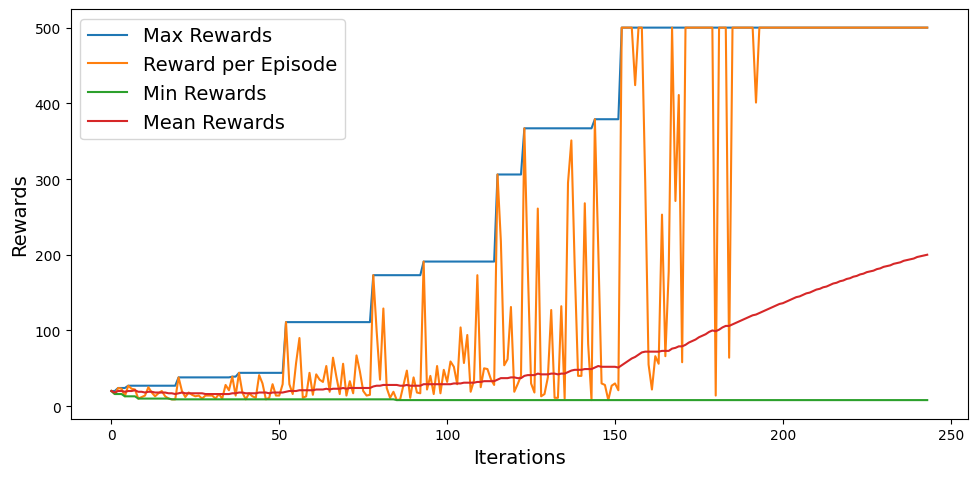

In [47]:
# Plot max_rewards
plt.figure(figsize=(10, 5))
plt.plot(iter, max_rew, label='Max Rewards')
plt.plot(iter, rew_eps, label='Reward per Episode')
plt.plot(iter, min_rew, label='Min Rewards')
plt.plot(iter, mean_rew, label='Mean Rewards')
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.legend()
save_fig("q_learning_rewards")
plt.show()

wow! I love Q-learning 💞

In [48]:
# Now use the updated Q-table to define a policy and show an episode. The show_one_episode function takes a policy function
# and a filename as input, runs an episode using the policy function, and saves a GIF of the episode to the filename.
show_one_episode(q, name='qlearning.gif')

<ipython-input-38-50a2869ea1fc>:9: RuntimeWarning: overflow encountered in scalar subtract
  bin_width = (upper_bounds[i] - lower_bounds[i]) / n_bins[i]   # Calculate the width of each bin.


Surely, it plays better than me...